# Learning a model

## What are we going to do today?
- Learn a simple model step by step (using synthetic data)
- What's a good predictive model?
- What can we do to obtain a good predictive model?

In contrast we will not focus on the Python and ML algorithms:

In [43]:
import numpy as np

import scipy as sp
from scipy.stats import norm

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams['figure.figsize'] = [8, 3]

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

from helper import make_simple_plot, make_plot

from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [44]:
LABEL_RELIGIOUS = 'fraction of religious people'
LABEL_ROMNEY = 'probability of voting for Romney'

In [45]:
display(HTML('<a title="United States Congress, Public domain, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Mitt_Romney_official_US_Senate_portrait_(3x4a).jpg"><img width="256" alt="Mitt Romney official US Senate portrait (3x4a)" src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Mitt_Romney_official_US_Senate_portrait_%283x4a%29.jpg/256px-Mitt_Romney_official_US_Senate_portrait_%283x4a%29.jpg"></a>'))

Imagine it's 2012.   
Mitt Romney is the presidential candidate for the Republican Party. 
You want to predict the outcome of the election or more specifically the **probability of voting for Mitt Romney in a county**.

Here economic and sociological factors are important, such as **poverty**, **race** and **religiousness**. 

There are historical correlations between such factors and election outcomes which we might want to incorporate into our model. An example of such a model might be:

*The odds of Romney winning are a function of population religiosity, race, poverty, education, and other social and economic indicators.*

We'll represent the **variable being predicted**, such as the probability of voting for Romney, by the letter $y$, and the **features** we use as an input in this probability by the letter $x$.   
This $x$ could be multi-dimensional, with $x_1$ being poverty, $x_2$ being race, and so on.

We then write: 

$$ y = f(x) $$

and our jobs is to take $x$ such as data from the census about race, religiousness, and so on, and $y$ as previous elections and surveys, and to make a predictive model for the elections. 

This means we wish to estimate $f(x)$.

### A real simple model
To gently step feet in the modelling world, lets consider a very simple model, where the **probability of voting for Romney** is a function only of how **religious the population in a county** is.

- $x$ be the fraction of religious people in a county  
- $y$ be the probability of voting for Romney as a function of $x$. 

### Collect data

In [46]:
display(HTML('<img src="./images/counties_1.png" alt="Drawing" style="width: 300px;"/> <p><b>Created with MapChart.</b></p> <a href="https://www.mapchart.net/usa-counties.html">https://www.mapchart.net/usa-counties.html</a>'))

You're only able to collect a limited number of data points.   
Let's imagine you're visiting **30 counties** all over the US and ask people who they will vote for in the upcoming election.   
The fraction of religios people in a county can be obtained from the census.  


The result is a sample $\cal{D}$ of 30 data points. Such data is called **in-sample data**. Contrastingly, the entire population of data points is also called **out-of-sample data**.

In [47]:
df=pd.read_csv("religion_sample_noise.csv")

In [48]:
df.head()

,promney,rfrac
0,0.108800,0.070000
1,0.170217,0.140000
2,0.171891,0.260000
3,0.163263,0.270000
4,0.242605,0.344716


In [49]:
len(df)

30

In [50]:
x=df.rfrac.values
y=df.promney.values

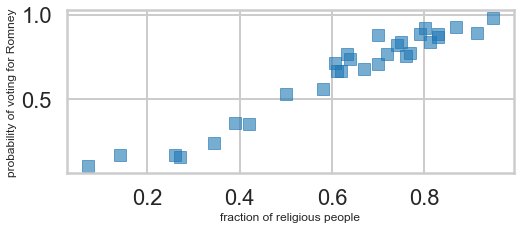

In [51]:
plt.plot(x,y,'s', alpha=0.6,);
plt.xlabel(LABEL_RELIGIOUS, fontsize=12);
plt.ylabel(LABEL_ROMNEY, fontsize=12);

<details>
    <summary>
        <font size=\"3\" color="green" ><b>What do you notice about the data?</b></font>
    </summary>
    <p>
    <ul>
        <li>The data is correlated</li>
        <li>In general: the more religious the people in a county the higher the probability of voting for Romney</li>
        <li>Both variables range from 0 to 1</li>
        <li>Sampling of x is not uniform: there are more points around x of 0.7</li>
    </ul>
    </p>

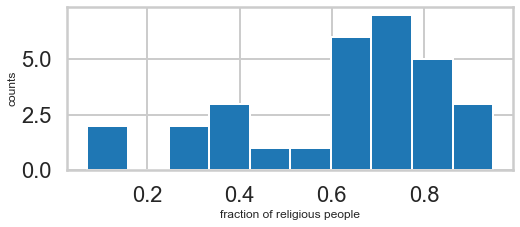

In [52]:
counts, bins = np.histogram(x)
plt.hist(bins[:-1], bins, weights=counts);
plt.xlabel(LABEL_RELIGIOUS, fontsize=12);
plt.ylabel('counts', fontsize=12);

Let's recap:  
You want to predict the **probability of voting for Mitt Romney in a county**. This is our $y$.

To achieve this, you defined a simple model $ y = f(x) $ where the probability of voting for Romney is a function of how religious the population in a county is.

You then collected a sample $\cal{D}$ of 30 data points. You now have $x$ and $y$ pairs like $(x_1, y_1), (x_2, y_2), ...$, but you still don't know $f$.

You now want to find a function $\hat{f}$ that might have generated these 30 points of sample data in the _hope_ that this function might approximate $f$ well, and provide us a **predictive model** for future data. This is known as **fitting** the data.

### Learn the best fit

Let's try to find a linear function, i.e. a straight line that best fits the data. Such a line can be described with the following function:
$$ y = f(x) = \beta_0 + \beta_1 x $$


**Which straight line best fits the data best?**

In [53]:
display(HTML('<img src="./images/linreg.png" alt="Drawing" style="width: 200px;"/>'))

We are looking for a straight line, that minimizes the distance from the points to that line.

Usually the **squared distances** are added up in a **loss function**

$$ L_{\cal{D}}(\hat{f}(x)) = \sum_{y_i \in \cal{D}} (y_i - \hat{f}(x_i))^2 $$


Now, given the sample for data $\cal{D}$, we minimize the loss over all possible functions $\hat{f}(x)$ to find the **best fit** function:

$$ \arg\min_{\hat{f}(x)} L_{\cal{D}}(\hat{f}(x)).$$

#### Detail information
Let's understand in an intuitive sense, what it means for a function to be a good fit to the data. Of all possible straight lines which can be described with $f(x) = \beta_0 + \beta_1 x$ which one is the best? In the figure below, we draw against the data points (in red) one such line (in red).

![m:Cost](./images/linreg.png)

The natural way of thinking about a "best fit" would be to minimize the distance from the line to the points, for some notion of distance. In the diagram we depict one such notion of distance: the vertical distance from the points to the line. These distances are represented as thin black lines.

The next question that then arises is this: how exactly we define the measure of this vertical distance? We can't take the measure of distance to be the y-value of the point minus the y value of the line at the same x, ie $y_i - f(x_i)$. Why? If we did this, then we could have points very far from the line, and as long as the total distance above was equal to the total distance below the line, we'd get a net distance of 0 even when the line is very far from the points.

Thus we must use a positive estimate of the distance as our measure. We could take either the absolute value of the distance, $\vert y_i - f(x_i) \vert$, or the square of the distance as our measure, $(y_i - f(x_i))^2$. Both are reasonable choices, and we shall use the **squared distance** for now. This approach of fitting the Linear Regression Model is called **Least Squares**.

We sum this measure up over all our data points, to create whats known as the **loss function** or **loss** of using line $f(x)$ to fit our points $y_i \in \cal{D}$ :

$$ L_{\cal{D}}(f(x)) = \sum_{y_i \in \cal{D}} (y_i - f(x_i))^2 $$


What this formula says is: the loss is just the total squared distance to the line from the observation points. 

Now, given the sample for data $\cal{D}$, we minimize the loss over all possible functions $f(x)$ to find the **best fit** function:

$$ \arg\min_{f(x)} L_{\cal{D}}(f(x)).$$

<details>
    <summary>
        <font size=\"3\" color="green"><b>How would you minimize the loss function $L$ and find the best fit function consequently?</b></font>
    </summary>
    <p>
    <ul>
        <li>Calculate the first derivative of the loss function $L$ and set the result to 0</li>
        <li>You can find a very good step by step guide on how to calculate $\beta_0$ and $\beta_1$ in Handl, Multivariate Analysemethoden, p. 206 </li>
        <li>You can also use a numeric approach like grandient descent</li>
    </ul>
    </p>

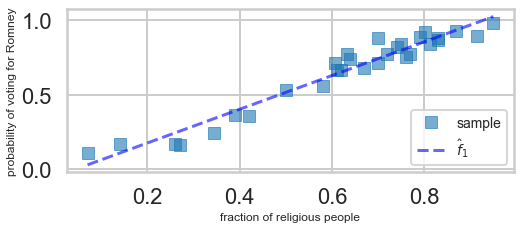

In [54]:
f_1 = np.poly1d(np.polyfit(x, y, 1));
plt.plot(x, y, 's', alpha=0.6, label="sample");
plt.plot(x, f_1(x), 'b--', alpha=0.6, label="$\hat{f}_1$");
plt.legend(loc=4, fontsize=14);
plt.xlabel(LABEL_RELIGIOUS, fontsize=12);
plt.ylabel(LABEL_ROMNEY, fontsize=12);

You have found the best-fit function to the data $\cal{D}$ from the set of all the straight lines.

### Bias
We need to keep in mind, that there is an underlying relationship between $x$ and $y$ that might not be linear, but of higher order. Consider a general case in the figure below, where a curvy $f$ is approximated by a function $\hat{f}$ which just does not have the wiggling that $f$ has. 

In [55]:
display(HTML('<img src="./images/bias.png" alt="Drawing" style="width: 200px;"/>'))

There is always going to be an error then, in approximating $f$ by $\hat{f}$. This *approximation error* is shown in the figure by the blue shaded region, and its called **bias**. The name comes from the fact that $\hat{f}$ just does not wiggle the way $f$ does (nothing will make a straight line curve). This happens when the model is too simple.  
A biased models leads to **underfitting**.

To address this risk we could simply define a more complex model like:
$$ y = f(x) = \beta_0 + \beta_1 x + \beta_2 x^2$$
Which is a *quadratic* function.

Or a *cubic* function:
$$ y = f(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 $$

Or in general a *polynomial* function of order $j$ :
$$ y = f(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + ... + \beta_m x^m = \sum_{j=0}^{m} \beta_j x^j$$

To see how a more complex model does, let's find the best fit 20th order polynomial.
$$y = f(x) = \sum_{j=0}^{20} \beta_j x^j\,.$$

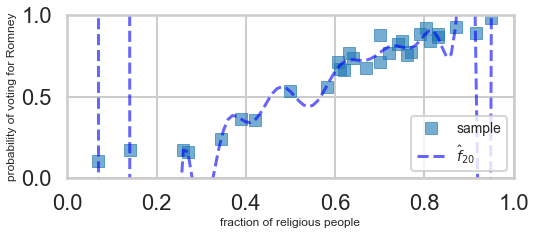

In [56]:
f_20 = np.poly1d(np.polyfit(x,y,20))
plt.plot(x,y, 's', alpha=0.6, label="sample");
plt.plot(np.arange(0,1,0.01),f_20(np.arange(0,1,0.01)), 'b--', alpha=0.6, label="$\hat{f}_{20}$");
plt.legend(loc=4, fontsize=14);
plt.ylim((0.0, 1.0));
plt.xlim((0.0, 1.0));
plt.xlabel(LABEL_RELIGIOUS, fontsize=12);
plt.ylabel(LABEL_ROMNEY, fontsize=12);

<details>
    <summary>
        <font size=\"3\" color="green"><b>How would you describe the fit?</b></font>
    </summary>
    <p>
    <ul>
        <li>The fit tracks the points much better than the straight line fit</li>
        <li>Or in other words: it follows every observation in very wiggle manner</li>
        <li>Between 0.4 < x < 0.8 the fit is more rubust than for smaller and bigger values of x </li>
    </ul>
    </p>

Let's quantify the quality of both fits by calculating the loss.

$$ L_{\cal{D}}(\hat{f}(x)) = \sum_{y_i \in \cal{D}} (y_i - \hat{f}(x_i))^2 $$

In [57]:
def loss(y, y_pred):
    return sum((y - y_pred)**2)
print('Loss of best straight line fit: ' + str(loss(y, f_1(x))))
print('Loss of best 20th order polynomial fit: ' + str(loss(y, f_20(x))))

Loss of best straight line fit: 0.11113035031356577
Loss of best 20th order polynomial fit: 0.03680751771730077


That's a very clear thing! the 20th order polynomial fit is way better then the straight line fit!

**Are you sure? Who thinks the 20th order polynomial is better? Raise your hands**

**Let's recall what you wanted to do**

We have a target function $f(x)$ that we do not know.   
But we do have a sample of data points from it, $(x_1,y_1), (x_2,y_2), ..., (x_n,y_n)$. We call this the **sample** $\cal{D}$.   
We are interested in using this sample to estimate a function $\hat{f}$ to approximate the function $f$, and which can be used for **prediction** at **new data points**, or on the **entire population**. 

To do this, we use an algorithm, called the **learner**, which chooses functions from a set of possible functions and computes a loss $L$ (like the sum of the squared distance over all points in the data set) for each of these functions. It then chooses the function $\hat{f}$ which **minimizes** this loss amonst all the functions. 

Here our learner is called **Polynomial Regression**, and it takes polynomials of order $j$, minimizes the "squared-error" loss measure, and spits out a best-fit hypothesis $\hat{f}_j$.

So again:  
You want to make good predictions on **new data points**.

You are trying to achive this by minimizing the loss on the set of data points we have (our sample) to find $\hat{f}$.

You then *hope* that the loss doesn't particulary change when we apply $\hat{f}$ on new data points or on the entire population.

### The role of sampling
An important pre-condition is that the sample is **representative of the population**. 

So if there are only highly religious counties representive in our sample (and we know that there are counties which aren't at all religious) we might run into a problem, i.e. the sample is not representative and the model we trained with the sample will do a bad job when applied on the entire population.
<details>
    <summary>
        <font size=\"3\" color="green" ><b>What else is important?</b></font>
    </summary>
    <p>
    <ul>
        <li>The size of the sample</li>
    </ul>
    </p>

You probably noticed that I used weasel words like "_might_" and "_hope_" when saying that representative sampling combined with the approach of minimizing the loss is what we need to learn a model.

We saw in the diagram above that $\hat{f}_{20}$ did a good job in tracking the observations, but we still weren't really happy with the result. It feels like $\hat{f}_{20}$ just memorized the data.

**So what's the problem?**

### Noise
Consider for example two customers of a bank with identical credit histories and salaries. One defaults on their mortgage, and the other does not. In this case we have identical $x = (credit, salary)$ for these two customers, but different $y$, which is a variable that is 1 if the customer defaulted and 0 otherwise. The true $y$ here might be a function of other features, such as marital strife, sickness of parents, etc. But, as the bank, we might not have this information. So we get different $y$ for different customers at the information $x$ that we possess.

A similar thing might be happen in the election example, where we have modelled the probability of voting for Romney as a function of religiousness of the county. There are **many other variables we might not have measured**, such as the majority race in that county, that affect $y$.

It gets worse. When pollsters estimate the number of people voting for a particular candidate, they only use finite samples of voters. So there is a 4-6\% polling error in any of these estimates. This "sampling noise" adds to the noisiness of the $y$'s.

### Systematic error

There is yet another class of errors called **systematic errors**. For example, sampling of respondents for an election might be done poorly. For example, if you were to only call people with land-lines to ask such questions, your respondents would likely skew older. And you would have a sampling bias in your polls. In the 2012 poll cycle, Rasmunnsen had a systematic bias in favor of republicans which had to be corrected for by various forecasters.[http://fivethirtyeight.blogs.nytimes.com/2012/11/10/which-polls-fared-best-and-worst-in-the-2012-presidential-race/?_r=0].

Similarly, in observing or experimenting with physical phenomenon, the measuring instruments might have a systematic error. For example, an altimeter needs to be callibrated to an altitude correcly. If you do this wrong, you will have wrong altitudes (by the same amount) everywhere. Also, if the weather changes while you are at that original altitude, you might lose that original callibration (since altimeters rely on air pressure, the altimeter will think you've moved to a different altitude). As another example, if a measuting rope has stretched out, your yardage  measurements on a football field might be different.

These sorts of errors cannot be modelled statistically and need to be dealt with on a case by case basis. They are not what we are talking about here, but as a modeler, you must be alert to their possibility or prescence.

So how to take **noise** into account?

Previously we said that
$$ y = f(x) $$

But this is not quite right. When considering noise

$$ y = f(x) + \epsilon $$

$\epsilon$ is a **random** noise term.

So in other words $y$ consists of
- underlying relationship between $x$ and $y$ (represented by the function $f(x)$) which we want to learn
- random noise $\epsilon$ we don't want to learn

We are not very interested in $\epsilon$, but we need to keep in mind that it's there and we need to make sure that the model doesn't fit the noise.

So let's have another look on our 20th order polynomial fit

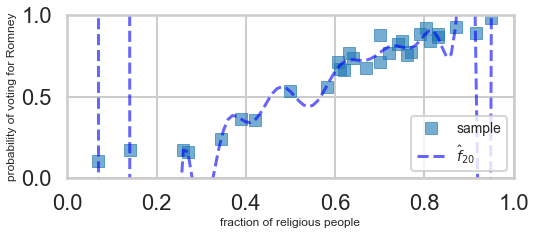

In [58]:
plt.plot(x,y, 's', alpha=0.6, label="sample");
plt.plot(np.arange(0,1,0.01),f_20(np.arange(0,1,0.01)), 'b--', alpha=0.6, label="$\hat{f}_{20}$");
plt.legend(loc=4, fontsize=14);
plt.ylim((0.0, 1.0));
plt.xlim((0.0, 1.0));
plt.xlabel(LABEL_RELIGIOUS, fontsize=12);
plt.ylabel(LABEL_ROMNEY, fontsize=12);

**What do you think? Who thinks that we are fitting the underlying relationship? Who thinks the noise?**

Let's recall! What's your goal? 

You want to predict the probability of voting for Mitt Romney in a counties **which are not part of our sample (a.k.a. out of sample data)**.

Let's do this. Let's visit another 30 counties, collect the real $y$, apply the prediction, and check how the model does!

In [59]:
df2=pd.read_csv("religion_sample_noise2.csv")
x2=df2.rfrac.values
y2=df2.promney.values

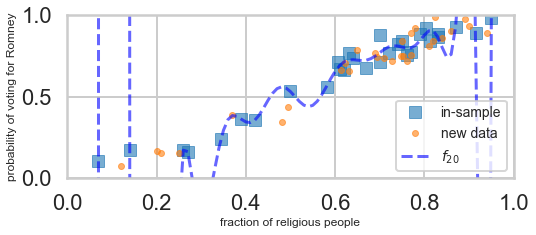

In [60]:
plt.plot(x, y, 's', alpha=0.6, label="in-sample");
plt.plot(x2, y2,  '.', alpha=0.6, label="new data");
plt.plot(np.arange(0,1,0.01),f_20(np.arange(0,1,0.01)), 'b--', alpha=0.6, label="$f_{20}$");
plt.ylim((0.0, 1.0));
plt.xlim((0.0, 1.0));
plt.legend(loc=4, fontsize=14);
plt.xlabel(LABEL_RELIGIOUS, fontsize=12);
plt.ylabel(LABEL_ROMNEY, fontsize=12);

The best-fit 20th order polynomial does a reasonable job fitting the in-sample data, and is even well behaved in the middle where we have a lot of in-sample data points. But at places with less in-sample data points, the polynomial wiggles maniacally.

This indicates that we fitted to the noise and this is a danger you will encounter again and again in learning. Its called **overfitting**. The take away lesson from this is that we must further ensure that our **model does not fit the noise**.

Let's recap:   
We have learned the meaning of **overfitting** and **underfitting**.  
- Overfitting: when model fits the noise  
- Underfitting: when model cannot capture the underlying relationship or trend of the data.  

In [61]:
display(HTML('<a title="Den Hieperboree at Dutch Wikipedia, CC BY-SA 2.5 &lt;https://creativecommons.org/licenses/by-sa/2.5&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Understeer-right-hand-drive.svg"><img width="128" alt="Understeer-right-hand-drive" src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f7/Understeer-right-hand-drive.svg/128px-Understeer-right-hand-drive.svg.png"></a>'))

In [62]:
display(HTML('<a title="The original uploader was Den Hieperboree at Dutch Wikipedia.(Original text: nl:Gebruiker:Den Hieperboree), CC BY-SA 2.5 &lt;https://creativecommons.org/licenses/by-sa/2.5&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Oversteer-right-hand-drive.svg"><img width="128" alt="Oversteer-right-hand-drive" src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9c/Oversteer-right-hand-drive.svg/128px-Oversteer-right-hand-drive.svg.png"></a>'))

**Understeering**: the car does not turn *enough* => **Underfitting**: the model does not fit the data *enough*  
**Oversteering**: the car turns *more* sharply *than intended* => **Overfitting**: the fit wiggles *more than intended*


Let's again quantify the quality of both fits by calculating the loss (but now on the new data!).

$$ L_{new\,data}(\hat{f}(x)) = \sum_{y_i \in \, new\,data} (y_i - \hat{f}(x_i))^2 $$

In [63]:
print('Loss of best straight line fit: ' + str(loss(y2, f_1(x2))))
print('Loss of best 20th order polynomial fit: ' + str(loss(y2, f_20(x2))))

Loss of best straight line fit: 0.11871102140565865
Loss of best 20th order polynomial fit: 22326.697260785684


This simple straight line (even it is biased) does better on new data than the way more sophisticated 20th order polynomial. 

### The Variance of your model

Let's stay a little longer at our 20th order polynomial model...

In order to retrieve the sample $\cal{D}$ you visited 30 counties, remember?

In [64]:
display(HTML('<img src="./images/counties_1.png" alt="Drawing" style="width: 500px;"/> <p><b>Created with MapChart.</b></p> <a href="https://www.mapchart.net/usa-counties.html">https://www.mapchart.net/usa-counties.html</a>'))

**How would our fit look like if we would have visited different counties?**

As our data is simulated anyways, let's see what happends if we choose **different 30 points randomly from the population**, and fit both linear and 20th order polynomial models to them. We do this on 200 sets of randomly chosen (from the population) data sets of 30 points each and plot the best fit models.

In [65]:
df_all=pd.read_csv("religion_noise.csv")


x_all=df_all.rfrac.values
y_all=df_all.promney.values

In [66]:
def gen(degree, nsims, size, x, y):
    """
    degree (int) degree of polynomial fit
    nsims (int) number of samples drawn from the population
    size (int) sample size
    x (array) x of population
    y (array) y of population
    """
    outpoly=[]
    for i in range(nsims):
        indexes=np.sort(np.random.choice(x.shape[0], size=size, replace=False))
        pc=np.polyfit(x[indexes], y[indexes], degree) # fitting the model
        p=np.poly1d(pc) 
        outpoly.append(p) # append polynomial function to list
    return outpoly

In [67]:
polys_1 = gen(1, 200, 30, x_all, y_all);
polys_20 = gen(20, 200, 30, x_all, y_all);

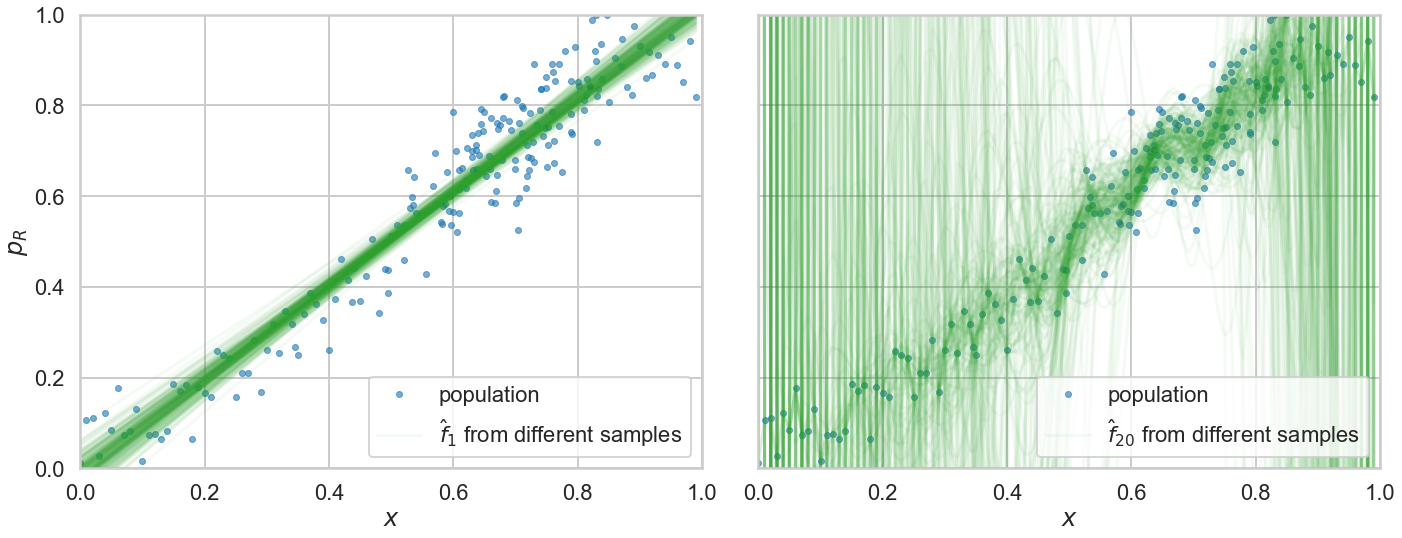

In [68]:
axes=make_plot()
axes[0].plot(x_all, y_all, '.', alpha=0.6, label="population");
axes[1].plot(x_all, y_all, '.', alpha=0.6, label="population");
c=sns.color_palette()[2]
for i, p in enumerate(polys_1[:-1]):
    axes[0].plot(x_all, p(x_all), alpha=0.05, c=c)
axes[0].plot(x_all, polys_1[-1](x_all), alpha=0.05, c=c,label="$\hat{f}_1$ from different samples")
for i, p in enumerate(polys_20[:-1]):
    axes[1].plot(x_all, p(x_all), alpha=0.05, c=c)
axes[1].plot(x_all, polys_20[-1](x_all), alpha=0.05, c=c, label="$\hat{f}_{20}$ from different samples")
axes[0].legend(loc=4);
axes[1].legend(loc=4);

On the left panel, you see the 200 best fit straight lines, each a fit on a different 30 point training sets from the 200 point population. The best-fit lines bunch together, even if they don't quite capture the underlying relationship terribly well. The different samples don't have a big influence in the fit. The fits look more or less the same. The model is quite robust.

On the right panel, we see the same with best-fits for 20th order polynomial models. It is a diaster. While most of the models still band around the central trend of the data $y$, a substantial amount of models veer off into all kinds of noisy hair all over the plot. This is **variance**: the predictions at any given $x$ are all over the place.

The variance can be seen in a different way by plotting the coefficients of the polynomial fit.

In [69]:
pdict1={}
pdict20={}
for i in reversed(range(2)):
    pdict1[i]=[]
    for j, p in enumerate(polys_1):
        pdict1[i].append(p.c[i])
for i in reversed(range(21)):
    pdict20[i]=[]
    for j, p in enumerate(polys_20):
        pdict20[i].append(p.c[i]) 
coeffs_1 = pd.DataFrame(pdict1)
coeffs_20 = pd.DataFrame(pdict20)

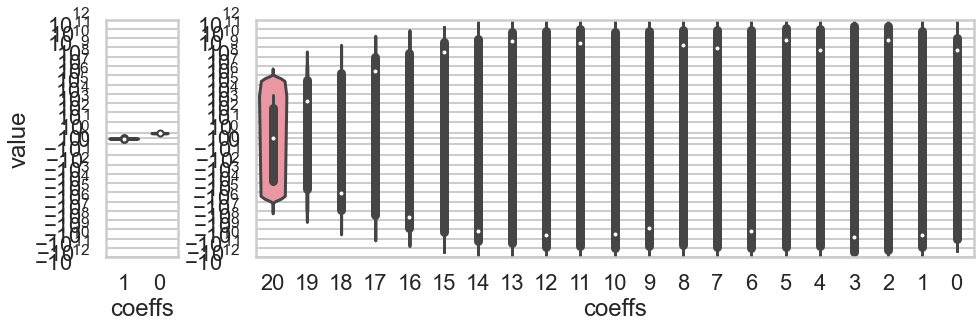

In [70]:
fig = plt.figure(figsize=(14, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 10]) 
axes = [plt.subplot(gs[0]), plt.subplot(gs[1])]
axes[0].set_ylabel("value")
axes[0].set_xlabel("coeffs")
axes[1].set_xlabel("coeffs")
plt.tight_layout();
sns.violinplot(data=coeffs_1, ax=axes[0]);
sns.violinplot(data=coeffs_20, ax=axes[1]);
axes[0].set_yscale("symlog");
axes[1].set_yscale("symlog");
axes[0].set_ylim([-1e12, 1e12]);
axes[1].set_ylim([-1e12, 1e12]);

In the right panel we plot the coefficients of the 20th order polynomial fits. This is why we use the word "variance": the spread in the values of the middle coefficients about their means is of the order $10^{10}$ (the vertical height of the bulges), with huge outliers!! The 20th order polynomial fits are a disaster!

Let's recap:

- You learned the basic formulation of the learning problem and a strategy using minimization of distance (called loss) to find the best fit model for the target function. 
- You learned the effect of noise on this fit, and the issues that crop up in learning target functions from data, chiefly the problem of overfitting to this noise. 
- You learned the meaning of over- and underfitting as well as bias and variance

The process of learning has two parts:

1. Fit for a model by minimizing the in-sample loss
2. Hope that the in-sample loss approximates the out-of-sample loss well.

Well, we are scientists. Just hoping does not befit us. But we only have a sample. 

**What can we do?**

We already did it. We realized that the 20th order polynomial fit was pretty bad, once we computed the loss of the fit on new data.  
As we ususally only have our sample, we need to hold back some of our sample, and test the performance of our learner by trying it out on this held back part! Perhaps we can compute the loss on the held-out part, or "test" part of our sample, and have something to say about the out-of-sample error.

### Testing and Training Sets
Let us introduce some new terminology. We take the sample of data $\cal{D}$ that we have been given (our in-sample set) and split it into two parts:

1. The **training set**, which is the part of the data we use to fit a model
2. The **testing set**, a smaller part of the data set which we use to see how good our fit was.

This split is done by choosing points at random into these two sets. Typically we might take 80% of our data and put it in the training set, with the remaining amount going into the test set.

![m:caption](images/train-test.png)

This has of course a downside: The amout of sample data is reduced. But there is no other way to figure out the generalization ability of the fit.

#### Detail information:  
Let us introduce some new terminology. We take the sample of data $\cal{D}$ that we have been given (our in-sample set) and split it into two parts:

1. The **training set**, which is the part of the data we use to fit a model
2. The **testing set**, a smaller part of the data set which we use to see how good our fit was.

This split is done by choosing points at random into these two sets. Typically we might take 80% of our data and put it in the training set, with the remaining amount going into the test set. This can be carried out in python using the `train_test_split` function from `sklearn.cross_validation`.

The split is shown in the diagram below:

![m:caption](images/train-test.png)

We ARE taking a hit on the amount of data we have to train our model. The more data we have, the better we can do for our fits. But, you cannot figure out the generalization ability of a learner by looking at the same data it was trained on: there is nothing to generalize to, and as we know we can fit very complex models to training data which have no hope of generalizing (like an interpolator). Thus, to estimate the **out-of-sample error or risk**, we must leave data over to make this estimation. 

At this point you are thinking: the test set is just another sample of the population, just like the training set. What guarantee do we have that it approximates the out-of-sample error well? And furthermore, if we pick 6 out of 30 points as a test set, why would you expect the estimate to be any good?

Its not possible to prove it in this course, but the test set error is a good estimate of the out of sample error, especially for larger and larger test sets. You are right to worry that 6 points is perhaps too few, but thats what we have for now, and we shall work with them.

We are **using the training set then, as our in-sample set, and the test set as a proxy for out-of-sample.**.

In [71]:
np.random.seed(0)
datasize=df.shape[0]
itrain,itest = train_test_split(range(30),train_size=24, test_size=6)
xtrain= x[itrain]
ytrain = y[itrain]
xtest= x[itest]
ytest = y[itest]

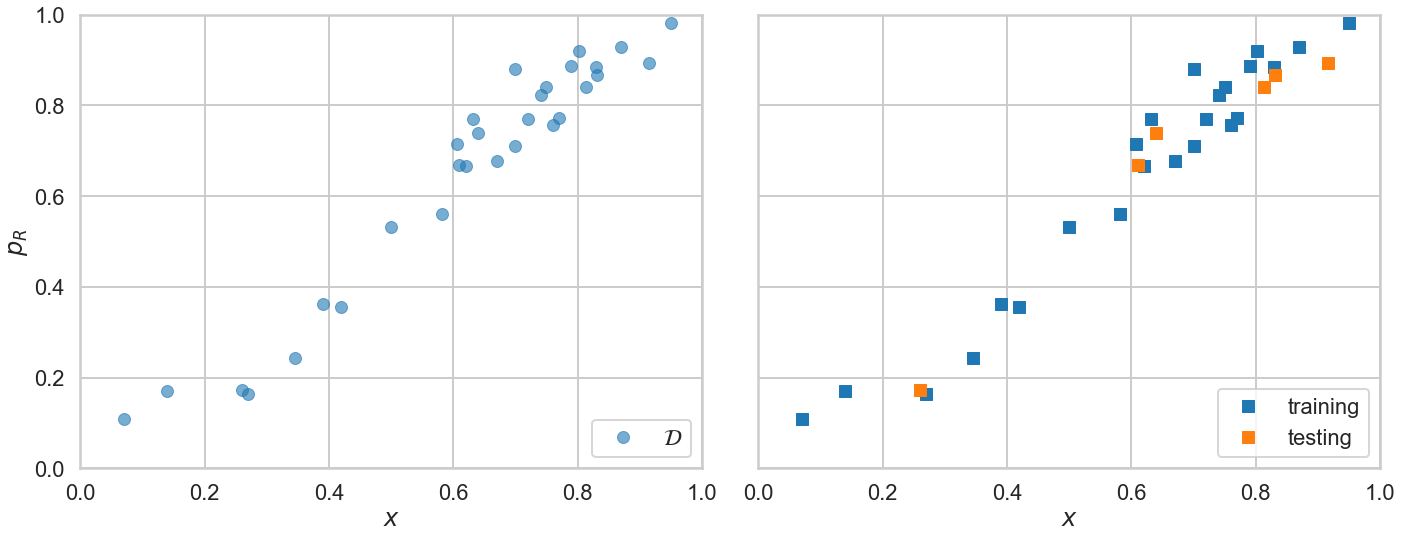

In [72]:
axes=make_plot();
axes[0].plot(x, y, 'o',alpha=0.6, label="$\cal{D}$");
axes[1].plot(xtrain, ytrain, 's', label="training");
axes[1].plot(xtest, ytest, 's', label="testing");
axes[0].legend(loc="lower right");
axes[1].legend(loc="lower right");

### How do training and testing error change with complexity?

The big question still is:   
What order of polynomial should we use to fit the data? Which order is too biased? Which one has too much variance and is too complex? Let us try and answer this question.

We do this by fitting 20 different models (remember the fit is made by minimizing the loss on the training set/the sample), each with increasing dimension `j`, and looking at the training-error and the test-error in each of these models.

In [73]:
def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist

In [74]:
degrees = range(21)
loss_train = np.empty(len(degrees))
loss_test = np.empty(len(degrees))

traintestlists = make_features(xtrain, xtest, degrees)

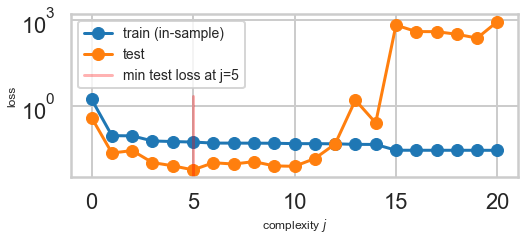

In [75]:
for d in degrees:#for increasing polynomial degrees 0,1,2...
    Xtrain = traintestlists[d]['train']
    Xtest = traintestlists[d]['test']
    #set up model
    est = LinearRegression()
    #fit
    est.fit(Xtrain, ytrain)
    #predict
    prediction_on_training = est.predict(Xtrain)
    prediction_on_test = est.predict(Xtest)
    #calculate loss
    loss_train[d] = loss(ytrain, prediction_on_training)
    loss_test[d] = loss(ytest, prediction_on_test)

plt.plot(degrees, loss_train, marker='o', label='train (in-sample)')
plt.plot(degrees, loss_test, marker='o', label='test')
plt.axvline(np.argmin(loss_test), 0,0.5, color='r', label="min test loss at j=%d"%np.argmin(loss_test), alpha=0.3)
plt.ylabel('loss', fontsize=12)
plt.xlabel('complexity $j$', fontsize=12)
plt.legend(loc='upper left', fontsize=14)
plt.yscale("log")

![m:caption](images/complexity-error-plot.png)

#### Detail information
The graph shows a very interesting structure. The training error decreases with increasing degree of the polynomial. This ought to make sense given what you know now: one can construct an arbitrarily complex polynomial to fit all the training data: indeed one could construct an order 24 polynomial which perfectly interpolates the 24 data points in the training set. You also know that this would do very badly on the test set as it would wiggle like mad to capture all the data points. And this is indeed what we see in the test set error. 

For extremely low degree polynomials like $d=0$ a flat line capturing the mean value of the data or $d=1$ a straight line fitting the data, the polynomial is not curvy enough to capture the contours of the data. We are in the bias error regime, where we will always have some difference between the data and the fit since the hypothesis is too simple. But, for degrees higher than 5, the polynomial starts to wiggle too much to capture the training data. The test set error increases as the predictive power of the polynomial goes down thanks to the contortions it must endure to fit the training data.

Thus the test set error first decreases as the model get more expressive, and then, once we exceed a certain level of complexity (here indexed by $d$), it increases. This idea can be used to identify just the right amount of complexity in the model by picking as **the best degree of model complexity as the one that minimizes test set error** or loss. In our case this happens at $d=5$. (This exact number will depend on the random points chosen into the training and test sets) For complexity lower than this critical value, identified by the red vertical line in the diagram, the model underfit; for complexity higher, they overfit.

![m:caption](images/complexity-error-plot.png)

We still have one problem.  

**Do you have an idea what's the problem?**

### Validation

We have used the test data to pick $j=5$. But by doing so we have used the test data to "fit" $j$.

$j$ is another parameter (we call it **hyperparameter**) of the model and this parameter (similar to the coefficients $\beta$) needs to be tested how it performs on data not used to fit the model.

![m:caption](images/train-validate-test.png)

There is a problem with the process above which is not apparent at first look. What we have done in picking $d=5$ as the best model complexity is that we have used the test set as a training set. How?

Our process used the training set to fit for the **parameters**(values of the coefficients) of the polynomial of given degree $d$ based on minimizing the traing set error (empirical risk minimization). We then calculated the error on the test set at that $d$. If we go further and choose the best $d$ based on minimizing the test set error, we have then "fit for" $d$ on the test set. We will thus call $d$ a **hyperparameter** of the model.

In this case, the test-set error will underestimate the true out-of-sample error (for a proof of this see Abu-Mostafa, Yaser S., Malik Magdon-Ismail, and Hsuan-Tien Lin. Learning from data. AMLBook, 2012.). Furthermore, we have **contaminated the test set** by fitting for $d$ on it; it is no longer a true test set.

Thus, we must introduce a new **validation set** on which the complexity parameter $d$ is fit, and leave out a test set which we can use to estimate the true out-of-sample performance of our learner. The place of this set in the scheme of things is shown below:

![m:caption](images/train-validate-test.png)

We have split the old training set into a training set and a validation set, holding the old test aside for FINAL testing AFTER we have "fit" for complexity $d$. Obviously we have decreased the size of the data available for training further, but this is a price we must pay for obtaining a good estimate of the out-of-sample risk $\cal{E}_{out}$ (also denoted as risk $R_{out}$) through the test risk $\cal{E}_{test}$ ($R_{test}$).

![m:caption](images/train-validate-test-cont.png)

The validation process is illustrated in these two figures. We first loop ober all the hypothesis sets that we wish to consider: in our case this is a loop over the complexity parameter $d$, the degree of the polynomials we will try and fit. Then for each degree $d$, we obtain a best fit model $g^-_d$ where the "minus" superscript indicates that we fit our model on the new training set which is obtained by removing ("minusing") a validation chunk (often the same size as the test chunk) from the old training set. We then "test" this model on the validation chunk, obtaining the validation error for the best-fit polynomial coefficients and for degree $d$. We move on to the next degree $d$ and repeat the process, just like before. We compare all the validation set errors, just like we did with the test errors earlier, and pick the degree $d_*$ which minimizes this validation set error.

![caption](images/train-validate-test3.png)

Having picked the hyperparameter $d_*$, we retrain using the hypothesis set $\cal{H}_{*}$ on the entire old training-set to find the parameters of the polynomial of order $d_*$ and the corresponding best fit hypothesis $g_*$. Note that we left the minus off the $g$ to indicate that it was trained on the entire old traing set. We now compute the test error on the test set as an estimate of the test risk $\cal{E}_{test}$.

Thus the **validation** set if the set on which the hyperparameter is fit. This method of splitting the data $\cal{D}$ is called the **train-validate-test** split.

We carry out this process for one training/validation split below. Note the smaller size of the new training set. We hold the test set at the same size.

In [76]:
#we split the training set down further
intrain,invalid = train_test_split(itrain,train_size=18, test_size=6)
xntrain= x[intrain]
yntrain = y[intrain]
xnvalid= x[invalid]
ynvalid = y[invalid]

degrees=range(21)
error_train=np.empty(len(degrees))
error_valid=np.empty(len(degrees))
trainvalidlists=make_features(xntrain, xnvalid, degrees)

for d in degrees:#for increasing polynomial degrees 0,1,2...
    #Create polynomials from x
    Xntrain = trainvalidlists[d]['train']
    Xnvalid = trainvalidlists[d]['test']
    #fit a model linear in polynomial coefficients on the new smaller training set
    est = LinearRegression()
    est.fit(Xntrain, yntrain)
    #predict on new training and validation sets and calculate mean squared error
    error_train[d] = mean_squared_error(yntrain, est.predict(Xntrain))
    error_valid[d] = mean_squared_error(ynvalid, est.predict(Xnvalid))

#calculate the degree at which validation error is minimized
mindeg = np.argmin(error_valid) 
ttlist=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
#predict on the test set now and calculate error
pred = clf.predict(ttlist[mindeg]['test'])
err = mean_squared_error(ytest, pred)

1


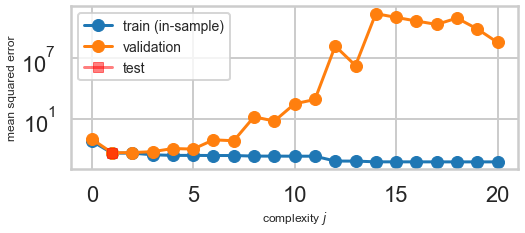

In [77]:
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='o', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')
plt.ylabel('mean squared error', fontsize=12)
plt.xlabel('complexity $j$', fontsize=12)
plt.legend(loc='upper left', fontsize=14)
plt.yscale("log")
print(mindeg)

The validation loss minimized at polynomial degree of 1.

Lets do this again, choosing a new random split between training and validation data: 

In [78]:
intrain,invalid = train_test_split(itrain,train_size=18, test_size=6)
xntrain= x[intrain]
yntrain = y[intrain]
xnvalid= x[invalid]
ynvalid = y[invalid]

degrees=range(21)
error_train=np.empty(len(degrees))
error_valid=np.empty(len(degrees))
trainvalidlists=make_features(xntrain, xnvalid, degrees)

for d in degrees:#for increasing polynomial degrees 0,1,2...
    #Create polynomials from x
    Xntrain = trainvalidlists[d]['train']
    Xnvalid = trainvalidlists[d]['test']
    #fit a model linear in polynomial coefficients on the training set
    est = LinearRegression()
    est.fit(Xntrain, yntrain)
    #calculate mean squared error
    error_train[d] = mean_squared_error(yntrain, est.predict(Xntrain))
    error_valid[d] = mean_squared_error(ynvalid, est.predict(Xnvalid))

mindeg = np.argmin(error_valid)
ttlist=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
pred = clf.predict(ttlist[mindeg]['test'])
err = mean_squared_error(ytest, pred)

3


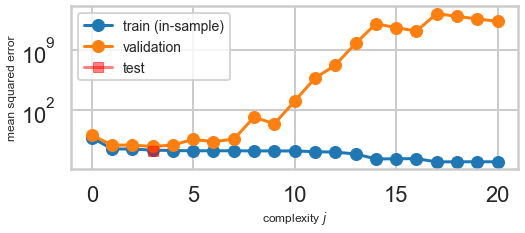

In [79]:
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='o', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')
plt.ylabel('mean squared error', fontsize=12)
plt.xlabel('complexity $j$', fontsize=12)
plt.legend(loc='upper left', fontsize=14)
plt.yscale("log")
print(mindeg)

This time the validation loss minimizing polynomial degree changed!   
**What happened?**

### Cross Validation
#### The Idea

The smaller the sample the higher the risk that there are specialities/peciliarity in the random splits. In order to not overestimate the loss due to some unfortunate train/test splits, **cross-validation** can be used:

- The train set is splitted into $k$-folds.
- For each model complexitiy (i.e. $j$-th order polynomial)
    - For each fold of the $k$-folds
        - the model is trained on $k-1$ parts
        - The loss is caluclated on the remaining (validation) part
    - In the end the average loss is calculated
- Select the model complexitiy based on the lowest loss
- Train the model on all $k$-folds
- Calculate the loss on the test set

In this way specialties are smoothed out

![m:caption](images/train-cv2.png)

#### Detail information
Remember that we chose a new random split? Since we are dealing with small data sizes here, you should worry that this exposes us to the peciliarity of the data set that got randomly chosen for us. This naturally leads us to want to choose multiple such random splits and somehow average over this process to find the "best" validation minimizing polynomial degree or complexity $d$.

Furthermore the validation set that we left out has two competing demands on it. The larger the set is, the better is our estimate of the out-of-sample error. So we'd like to hold out as much as possible.

But the smaller the validation set is, the more data we have to train ourmodel on. Thus we can fit a better, more expressive model.

We want to balance these two desires, and additionally, not be exposed to any peculiarities that might randomly arise in any single train-validate split of the old training set.

To deal with this we engage in a process called **cross-validation**, which is illustrated in the figure below, for a given hypothesis set $\cal{H}_a$ with complexity parameter $d=a$ (the polynomial degree). We do the train/validate split, not once but multiple times. 

In the figure below we create 4-folds from the training set part of our data set $\cal{D}$. By this we mean that we divide our set roughly into 4 equal parts. As illustrated below, this can be done in 4 different ways, or folds. In each fold we train a model on 3 of the parts. The model so trained is denotet as $g^-_{Fi}$, for example $g^-_{F3}$ . The minus sign in the superscript once again indicates that we are training on a reduced set. The $F3$ indicates that this model was trained on the third fold. Note that the model trained on each fold will be different!

For each fold, after training the model, we calculate the risk or error on the remaining one validation part. We then add the validation errors together from the different folds, and divide by the number of folds to calculate an average error. Note again that this average error is an average over different models $g^-_{Fi}$. We use this error as the validation error for $d=a$ in the validation process described earlier.

![m:caption](images/train-cv2.png)

Note that the number of folds is equal to the number of splits in the data. For example, if we have 5 splits, there will be 5 folds. To illustrate cross-validation consider below fits in $\cal{H}_0$ and $\cal{H}_1$ (means and straight lines) to a sine curve, with only 3 data points.

### The entire description of K-fold Cross-validation

We put thogether this scheme to calculate the error for a given polynomial degree $d$ with the method we used earlier to choose a model given the validation-set risk as a function of $d$:

1. create `n_folds` partitions of the training data. 
2. We then train on `n_folds -1` of these partitions, and test on the remaining partition. There are `n_folds` such combinations of partitions (or folds), and thus we obtain `n_fold` risks.
3. We average the error or risk of all such combinations to obtain, for each value of $d$, $R_{dCV}$.
4. We move on to the next value of $d$, and repeat 3
5. and then find the optimal value of d that minimizes risk $d=*$.
5. We finally use that value to make the final fit in $\cal{H}_*$ on the entire old training set.

![caption](images/train-cv3.png)

It can also shown that **cross-validation error is an unbiased estimate of the out of sample-error**.

Let us now do 4-fold cross-validation on our Romney votes data set. We increase the complexity from degree 0 to degree 20. In each case we take the old training set, split in 4 ways into 4 folds, train on 3 folds, and calculate the validation error on the ramining one. We then average the erros over the four folds to get a cross-validation error for that $d$. Then we did what we did before: find the hypothesis space $\cal{H}_*$ with the lowest cross-validation error, and refit it using the entire training set. We can then use the test set to estimate $E_{out}$.

In [80]:
n_folds=4
degrees=range(21)
results=[]
kf = KFold(n_folds)
for d in degrees:
    hypothesisresults=[]
    for train, test in kf.split(range(24)): # split data into train/test groups, 4 times
        tvlist=make_features(xtrain[train], xtrain[test], degrees)
        clf = LinearRegression()
        clf.fit(tvlist[d]['train'], ytrain[train]) # fit
        hypothesisresults.append(mean_squared_error(ytrain[test], clf.predict(tvlist[d]['test']))) # evaluate score function on held-out data
    results.append((np.mean(hypothesisresults), np.min(hypothesisresults), np.max(hypothesisresults))) # average

In [81]:
mindeg = np.argmin([r[0] for r in results])
ttlist=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
pred = clf.predict(ttlist[mindeg]['test'])
err = mean_squared_error(pred, ytest)
errtr=mean_squared_error(ytrain, clf.predict(ttlist[mindeg]['train']))
c0=sns.color_palette()[0]

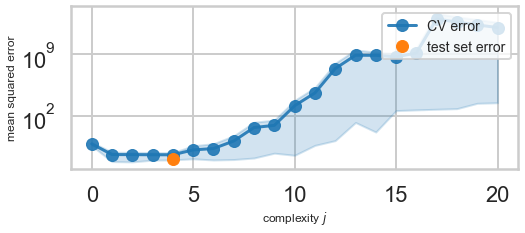

In [82]:
plt.plot(degrees, [r[0] for r in results], marker='o', label='CV error', alpha=0.9)
plt.fill_between(degrees, [r[1] for r in results], [r[2] for r in results], color=c0, alpha=0.2)
plt.plot([mindeg], [err], 'o',  label='test set error')
plt.ylabel('mean squared error', fontsize=12)
plt.xlabel('complexity $j$', fontsize=12)
plt.legend(loc='upper right', fontsize=14)
plt.yscale("log")

We see that the cross-validation loss minimizes at a low degree, and then increases. Because we have so few data points the spread in fold losses increases as well.

In [83]:
y_hat = clf.predict(PolynomialFeatures(4).fit_transform(np.arange(0,1,0.01).reshape(-1,1)))

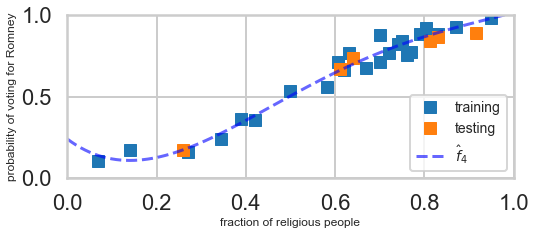

In [84]:
plt.plot(xtrain, ytrain, 's', label="training");
plt.plot(xtest, ytest, 's', label="testing");
plt.plot(np.arange(0,1,0.01), y_hat, 'b--', alpha=0.6, label="$\hat{f}_{4}$");
plt.ylim((0.0, 1.0));
plt.xlim((0.0, 1.0));
plt.legend(loc=4, fontsize=14);
plt.xlabel(LABEL_RELIGIOUS, fontsize=12);
plt.ylabel(LABEL_ROMNEY, fontsize=12);

## Recap
1. We started with a real world problem
    - find a predictive model which is able to predict the outcome of an election (probability of people voting for Romney in a county)
1. Formulated a model
    - factors which affects the outcome of the election
    - $y = f(x)$ with x fraction of religious people in a county
1. Gathered sample data $\cal{D}$
1. Fitting the data
    - Goal: getting $\hat{f}$ which is an estimation of $f$ by using the sample data
    - Started by fitting a straight line
1. Bias and Underfitting
1. Fitting the data again (by allowing more complexitiy)
1. Noise, Variance and Overfitting
1. Train- & Test-Split
1. Train-, Validation- & Test-Split
1. $k$-fold Cross Validation